# Features Engineering

Our data can be very high dimensional if we consider the number of languages, countries, actors etc. We have only 44k movies, but we have several hundreds on genres, languages and countries, which gives already around 10 millions possibilities. And this is without even looking at the hundreds of thousands of actors and characters. Thus we have to come up with features that can capture signal in the data, without having to do one-hot encoding for each feature.

## Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
country_df = pd.read_pickle("../../data/post_processing//country_df.pkl")
comes_from_df = pd.read_pickle("../../data/post_processing/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/post_processing/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/post_processing/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/post_processing/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/post_processing/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/post_processing/character_df.pkl")
actor_df = pd.read_pickle("../../data/post_processing/actor_df.pkl")
movie_df = pd.read_pickle("../../data/post_processing/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/post_processing/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/post_processing/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/post_processing/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")

## Countries

For the countries we can already try to group per continent. It will give an idea of the different local influence without going in too much details. We suggest the following partition based on our previous analyses:

- North America and Australia
- Central and South America
- Western Europe
- Eastern Europe and Russia
- Africa and Middle-East
- Asia

In [3]:
CONTINENT_ID = {"North America and Australia": [1,0,0,0,0,0],
"Central and South America": [0,1,0,0,0,0],
"Western Europe": [0,0,1,0,0,0],
"Eastern Europe and Russia": [0,0,0,1,0,0],
"Africa and Middle-East": [0,0,0,0,1,0],
"Asia": [0,0,0,0,0,1]}

COUNTRY_CONTINENT_MAPPING = {
'afghanistan' : "Africa and Middle-East",
 'albania' : "Eastern Europe and Russia",
 'algeria' : "Africa and Middle-East",
 'argentina': "Central and South America",
 'armenia' : "Africa and Middle-East",
 'aruba': "Central and South America",
 'australia': "North America and Australia",
 'austria': "Western Europe",
 'azerbaijan' : "Africa and Middle-East",
 'bahamas': "Central and South America",
 'bahrain' : "Africa and Middle-East",
 'bangladesh': "Asia",
 'belgium': "Western Europe",
 'bhutan': "Asia",
 'bolivia': "Central and South America",
 'bosnia and herzegovina' : "Eastern Europe and Russia",
 'brazil': "Central and South America",
 'bulgaria' : "Eastern Europe and Russia",
 'burkina faso' : "Africa and Middle-East",
 'burma': "Asia",
 'cambodia': "Asia",
 'cameroon' : "Africa and Middle-East",
 'canada': "North America and Australia",
 'chile': "Central and South America",
 'china': "Asia",
 'colombia': "Central and South America",
 'congo' : "Africa and Middle-East",
 'costa rica': "Central and South America",
 'crime' : "Eastern Europe and Russia",
 'croatia' : "Eastern Europe and Russia",
 'cuba': "Central and South America",
 'cyprus' : "Eastern Europe and Russia",
 'czech republic' : "Eastern Europe and Russia",
 'czechoslovakia' : "Eastern Europe and Russia",
 'democratic republic of the congo' : "Africa and Middle-East",
 'denmark': "Western Europe",
 'egypt' : "Africa and Middle-East",
 'estonia' : "Eastern Europe and Russia",
 'ethiopia' : "Africa and Middle-East",
 'finland': "Western Europe",
 'france': "Western Europe",
 'georgia' : "Africa and Middle-East",
 'germany': "Western Europe",
 'greece' : "Eastern Europe and Russia",
 'haiti': "Central and South America",
 'hong kong': "Asia",
 'hungary' : "Eastern Europe and Russia",
 'iceland': "Western Europe",
 'india': "Asia",
 'indonesia': "Asia",
 'iran' : "Africa and Middle-East",
 'iraq' : "Africa and Middle-East",
 'iraqi kurdistan' : "Africa and Middle-East",
 'ireland': "Western Europe",
 'isle of man': "Western Europe",
 'israel' : "Africa and Middle-East",
 'italy': "Western Europe",
 'jamaica': "Central and South America",
 'japan': "Asia",
 'jordan' : "Africa and Middle-East",
 'kenya' : "Africa and Middle-East",
 'korea': "Asia",
 'kuwait' : "Africa and Middle-East",
 'lebanon' : "Africa and Middle-East",
 'libya' : "Africa and Middle-East",
 'lithuania' : "Eastern Europe and Russia",
 'luxembourg': "Western Europe",
 'macau': "Asia",
 'malaysia': "Asia",
 'mali' : "Africa and Middle-East",
 'malta': "Western Europe",
 'mexico': "Central and South America",
 'monaco': "Western Europe",
 'mongolia': "Asia",
 'montenegro' : "Eastern Europe and Russia",
 'morocco' : "Africa and Middle-East",
 'nepal': "Asia",
 'netherlands': "Western Europe",
 'new zealand': "North America and Australia",
 'nigeria' : "Africa and Middle-East",
 'norway': "Western Europe",
 'pakistan' : "Africa and Middle-East",
 'palestinian territories' : "Africa and Middle-East",
 'panama': "Central and South America",
 'peru': "Central and South America",
 'philippines': "Asia",
 'poland' : "Eastern Europe and Russia",
 'portugal': "Western Europe",
 'puerto rico': "Central and South America",
 'republic of macedonia' : "Eastern Europe and Russia",
 'romania' : "Eastern Europe and Russia",
 'russia' : "Eastern Europe and Russia",
 'senegal' : "Africa and Middle-East",
 'serbia' : "Eastern Europe and Russia",
 'serbia and montenegro' : "Eastern Europe and Russia",
 'singapore': "Asia",
 'slovakia' : "Eastern Europe and Russia",
 'slovenia' : "Eastern Europe and Russia",
 'south africa' : "Africa and Middle-East",
 'south korea': "Asia",
 'spain': "Western Europe",
 'sri lanka': "Asia",
 'sweden': "Western Europe",
 'switzerland': "Western Europe",
 'taiwan': "Asia",
 'thailand': "Asia",
 'tunisia' : "Africa and Middle-East",
 'turkey' : "Africa and Middle-East",
 'ukraine' : "Eastern Europe and Russia",
 'united arab emirates' : "Africa and Middle-East",
 'united kingdom': "Western Europe",
 'united states of america': "North America and Australia",
 'uruguay': "Central and South America",
 'uzbekistan' : "Africa and Middle-East",
 'venezuela': "Central and South America",
 'vietnam': "Asia",
 'yugoslavia' : "Eastern Europe and Russia",
 'zambia' : "Africa and Middle-East",
 'zimbabwe' : "Africa and Middle-East"
}

## Actors

For the actors, we thought about the following features:
- #number of actors in the top 5% (or 1% ?)
- #number of actors
- mean actor age
- gender balance

In [17]:
actor_movie_count = appears_in_df.groupby("actor_id")["movie_id"].count().values
threshold = np.percentile(actor_movie_count,95)
is_actor_above_threshold = appears_in_df.groupby("actor_id")["movie_id"].count().sort_index() >= threshold
top_k_actors = actor_df[is_actor_above_threshold.values]

<AxesSubplot:ylabel='Count'>

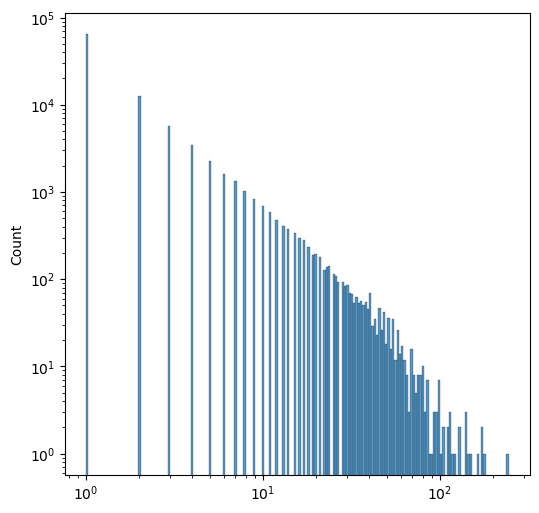

In [41]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_yscale("log")
ax.set_xscale("log")
sns.histplot(appears_in_df.groupby("actor_id")["movie_id"].count().values,ax=ax)